In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchsummary import summary

import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline
torch.manual_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


In [3]:
train_data = datasets.CIFAR10(
    root = '../data/',
    train = True,                    
    transform = ToTensor(), 
    download = True,            
)

In [4]:
dataloader = DataLoader(train_data, 50000, shuffle=False, num_workers=2)
X, _ = next(iter(dataloader))
mean, std = torch.mean(X).item(), torch.std(X).item()

In [5]:
train_data = datasets.CIFAR10(
    root = '../data/',
    train = True,                    
    transform = Compose([ToTensor(), Normalize(mean, std)]),
    download = True,
)

test_data = datasets.CIFAR10(
    root = '../data/', 
    train = False, 
    transform = Compose([ToTensor(), Normalize(mean, std)]),
    download = True
)

In [6]:
train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])

## Architecture

In [7]:
class Baseline(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

In [8]:
def run_epoch(model, dataloader, optimizer, criterion, train=True):
    """
    Runs one epoch for training or validation.
    """
    epoch_loss = 0
    correct = 0
    total_samples = len(dataloader.dataset)

    if train:
        model.train()
    else:
        model.eval()

    for X, y in tqdm(dataloader, desc=f'{"Train" if train else "Val"} Epoch'):
        X, y = X.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            output = model(X)
            loss = criterion(output, y)

        epoch_loss += loss.item()
        _, y_pred = torch.max(output, dim=1)
        correct += torch.sum(y_pred == y).item()

        if train:
            loss.backward()
            optimizer.step()

    avg_loss = epoch_loss / len(dataloader)
    accuracy = correct / total_samples

    return avg_loss, accuracy

def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs, patience=None, delta=None):
    """
    Trains and evaluates the model for n_epochs.
    """
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(n_epochs):

        print(f'\nEpoch {epoch+1}/{n_epochs}')
        print('----------')

        train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, train=True)
        val_loss, val_acc = run_epoch(model, val_loader, optimizer, criterion, train=False)
            
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        epoch_train_accs.append(train_acc)
        epoch_val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}\nVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        if patience == None and delta == None:
            continue
        else:
            if val_loss < best_val_loss - delta:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                print(f'Val loss has not increased for {counter}/{patience} epochs')
                if counter >= patience:
                    print(f'Training stopped after {epoch+1} epochs')
                    break
    
    return epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs

## Init

In [9]:
results = {}
n_epochs = 10

train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1024, shuffle=False)

## Baseline with ReLU

In [10]:
model = Baseline(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results['baseline_relu'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.34it/s]


Train Loss: 1.9945, Train Accuracy: 0.2687
Val Loss: 1.8380, Val Accuracy: 0.3402

Epoch 2/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.45it/s]


Train Loss: 1.6716, Train Accuracy: 0.3865
Val Loss: 1.5900, Val Accuracy: 0.4292

Epoch 3/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.47it/s]


Train Loss: 1.5139, Train Accuracy: 0.4474
Val Loss: 1.5549, Val Accuracy: 0.4436

Epoch 4/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s]


Train Loss: 1.4216, Train Accuracy: 0.4856
Val Loss: 1.4362, Val Accuracy: 0.4863

Epoch 5/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s]


Train Loss: 1.3463, Train Accuracy: 0.5133
Val Loss: 1.3903, Val Accuracy: 0.5031

Epoch 6/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s]


Train Loss: 1.2885, Train Accuracy: 0.5372
Val Loss: 1.3175, Val Accuracy: 0.5324

Epoch 7/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]


Train Loss: 1.2424, Train Accuracy: 0.5543
Val Loss: 1.3206, Val Accuracy: 0.5219

Epoch 8/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.28it/s]


Train Loss: 1.1889, Train Accuracy: 0.5767
Val Loss: 1.3177, Val Accuracy: 0.5469

Epoch 9/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


Train Loss: 1.1365, Train Accuracy: 0.5960
Val Loss: 1.1509, Val Accuracy: 0.5973

Epoch 10/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.92it/s]

Train Loss: 1.1063, Train Accuracy: 0.6093
Val Loss: 1.2260, Val Accuracy: 0.5721


## Baseline with Tanh

In [11]:
model = Baseline(activation=nn.Tanh()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results['baseline_tanh'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.75it/s]


Train Loss: 1.8513, Train Accuracy: 0.3331
Val Loss: 1.6014, Val Accuracy: 0.4260

Epoch 2/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.66it/s]


Train Loss: 1.4680, Train Accuracy: 0.4704
Val Loss: 1.3910, Val Accuracy: 0.4981

Epoch 3/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.17it/s]


Train Loss: 1.2900, Train Accuracy: 0.5330
Val Loss: 1.2869, Val Accuracy: 0.5392

Epoch 4/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


Train Loss: 1.1641, Train Accuracy: 0.5859
Val Loss: 1.1472, Val Accuracy: 0.5942

Epoch 5/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.94it/s]


Train Loss: 1.0683, Train Accuracy: 0.6248
Val Loss: 1.0823, Val Accuracy: 0.6220

Epoch 6/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.97it/s]


Train Loss: 0.9870, Train Accuracy: 0.6509
Val Loss: 0.9985, Val Accuracy: 0.6509

Epoch 7/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.02it/s]


Train Loss: 0.9127, Train Accuracy: 0.6808
Val Loss: 0.9509, Val Accuracy: 0.6659

Epoch 8/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.38it/s]


Train Loss: 0.8519, Train Accuracy: 0.7044
Val Loss: 0.9517, Val Accuracy: 0.6665

Epoch 9/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.07it/s]


Train Loss: 0.8123, Train Accuracy: 0.7161
Val Loss: 0.8835, Val Accuracy: 0.6875

Epoch 10/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.06it/s]

Train Loss: 0.7593, Train Accuracy: 0.7334
Val Loss: 0.9034, Val Accuracy: 0.6869


## BatchNorm

In [12]:
class BatchNorm(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.activation(self.bn4(self.fc1(x)))
        x = self.activation(self.bn5(self.fc2(x)))
        return self.fc3(x)

In [13]:
activations = {'relu': nn.ReLU(), 'tanh': nn.Tanh()}

for name, function in activations.items():
    model = BatchNorm(activation=function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
    results[f'batchnorm_{name}'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.19it/s]


Train Loss: 1.5778, Train Accuracy: 0.4768
Val Loss: 1.3817, Val Accuracy: 0.5500

Epoch 2/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.44it/s]


Train Loss: 1.0912, Train Accuracy: 0.6404
Val Loss: 1.0768, Val Accuracy: 0.6322

Epoch 3/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.22it/s]


Train Loss: 0.8793, Train Accuracy: 0.7040
Val Loss: 0.9620, Val Accuracy: 0.6719

Epoch 4/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s]


Train Loss: 0.7457, Train Accuracy: 0.7464
Val Loss: 0.9446, Val Accuracy: 0.6727

Epoch 5/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s]


Train Loss: 0.6550, Train Accuracy: 0.7773
Val Loss: 0.8348, Val Accuracy: 0.7123

Epoch 6/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.11it/s]


Train Loss: 0.5633, Train Accuracy: 0.8119
Val Loss: 1.1935, Val Accuracy: 0.6107

Epoch 7/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.66it/s]


Train Loss: 0.5089, Train Accuracy: 0.8309
Val Loss: 0.8493, Val Accuracy: 0.7104

Epoch 8/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.98it/s]


Train Loss: 0.4351, Train Accuracy: 0.8558
Val Loss: 0.8473, Val Accuracy: 0.7156

Epoch 9/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.98it/s]


Train Loss: 0.3610, Train Accuracy: 0.8861
Val Loss: 0.9045, Val Accuracy: 0.7074

Epoch 10/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.64it/s]


Train Loss: 0.3230, Train Accuracy: 0.8955
Val Loss: 0.9291, Val Accuracy: 0.7080

Epoch 1/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.83it/s]


Train Loss: 1.5964, Train Accuracy: 0.4456
Val Loss: 1.4318, Val Accuracy: 0.5037

Epoch 2/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.17it/s]


Train Loss: 1.2425, Train Accuracy: 0.5725
Val Loss: 1.1779, Val Accuracy: 0.5957

Epoch 3/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.82it/s]


Train Loss: 1.0564, Train Accuracy: 0.6364
Val Loss: 1.1074, Val Accuracy: 0.6132

Epoch 4/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s]


Train Loss: 0.9321, Train Accuracy: 0.6799
Val Loss: 1.1277, Val Accuracy: 0.6092

Epoch 5/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s]


Train Loss: 0.8411, Train Accuracy: 0.7102
Val Loss: 1.0377, Val Accuracy: 0.6411

Epoch 6/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.35it/s]


Train Loss: 0.7846, Train Accuracy: 0.7311
Val Loss: 0.9780, Val Accuracy: 0.6609

Epoch 7/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


Train Loss: 0.7189, Train Accuracy: 0.7515
Val Loss: 1.0411, Val Accuracy: 0.6367

Epoch 8/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s]


Train Loss: 0.6467, Train Accuracy: 0.7788
Val Loss: 1.0724, Val Accuracy: 0.6408

Epoch 9/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.07it/s]


Train Loss: 0.5940, Train Accuracy: 0.7994
Val Loss: 1.0127, Val Accuracy: 0.6623

Epoch 10/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.23it/s]

Train Loss: 0.5480, Train Accuracy: 0.8135
Val Loss: 1.0115, Val Accuracy: 0.6633


## Dropout without BatchNorm

In [14]:
class Dropout(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        return self.fc3(x)

In [15]:
activations = {'relu': nn.ReLU(), 'tanh': nn.Tanh()}

for name, function in activations.items():
    model = Dropout(activation=function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
    results[f'dropout_{name}'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.86it/s]


Train Loss: 2.1268, Train Accuracy: 0.2007
Val Loss: 1.8178, Val Accuracy: 0.3396

Epoch 2/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.36it/s]


Train Loss: 1.8240, Train Accuracy: 0.3174
Val Loss: 1.6170, Val Accuracy: 0.4042

Epoch 3/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.17it/s]


Train Loss: 1.6661, Train Accuracy: 0.3789
Val Loss: 1.4907, Val Accuracy: 0.4569

Epoch 4/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.06it/s]


Train Loss: 1.5758, Train Accuracy: 0.4173
Val Loss: 1.4018, Val Accuracy: 0.4864

Epoch 5/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.70it/s]


Train Loss: 1.5161, Train Accuracy: 0.4415
Val Loss: 1.4413, Val Accuracy: 0.4842

Epoch 6/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.19it/s]


Train Loss: 1.4785, Train Accuracy: 0.4676
Val Loss: 1.3055, Val Accuracy: 0.5361

Epoch 7/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s]


Train Loss: 1.4165, Train Accuracy: 0.4906
Val Loss: 1.2654, Val Accuracy: 0.5491

Epoch 8/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.53it/s]


Train Loss: 1.3753, Train Accuracy: 0.5023
Val Loss: 1.2795, Val Accuracy: 0.5396

Epoch 9/10
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


Train Loss: 1.3563, Train Accuracy: 0.5153
Val Loss: 1.2285, Val Accuracy: 0.5719

Epoch 10/10
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Train Loss: 1.3219, Train Accuracy: 0.5268
Val Loss: 1.1804, Val Accuracy: 0.5849

Epoch 1/10
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


Train Loss: 1.9618, Train Accuracy: 0.2752
Val Loss: 1.6646, Val Accuracy: 0.4160

Epoch 2/10
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Train Loss: 1.6195, Train Accuracy: 0.4028
Val Loss: 1.4635, Val Accuracy: 0.4768

Epoch 3/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.51it/s]


Train Loss: 1.4803, Train Accuracy: 0.4592
Val Loss: 1.3179, Val Accuracy: 0.5292

Epoch 4/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.04it/s]


Train Loss: 1.3853, Train Accuracy: 0.5005
Val Loss: 1.2543, Val Accuracy: 0.5464

Epoch 5/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.61it/s]


Train Loss: 1.3319, Train Accuracy: 0.5178
Val Loss: 1.1955, Val Accuracy: 0.5678

Epoch 6/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.23it/s]


Train Loss: 1.2815, Train Accuracy: 0.5434
Val Loss: 1.1243, Val Accuracy: 0.5999

Epoch 7/10
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s]


Train Loss: 1.2312, Train Accuracy: 0.5629
Val Loss: 1.0977, Val Accuracy: 0.6140

Epoch 8/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.47it/s]


Train Loss: 1.2001, Train Accuracy: 0.5735
Val Loss: 1.1236, Val Accuracy: 0.6011

Epoch 9/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.47it/s]


Train Loss: 1.1792, Train Accuracy: 0.5865
Val Loss: 1.0201, Val Accuracy: 0.6417

Epoch 10/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.25it/s]

Train Loss: 1.1378, Train Accuracy: 0.6009
Val Loss: 1.0300, Val Accuracy: 0.6442


## Dropout with BatchNorm

In [16]:
class DropoutBatchNorm(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dropout(self.activation(self.bn4(self.fc1(x))))
        x = self.dropout(self.activation(self.bn5(self.fc2(x))))
        return self.fc3(x)

In [17]:
model = DropoutBatchNorm(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results[f'dropout_batchnorm_relu'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.72it/s]


Train Loss: 2.0347, Train Accuracy: 0.2562
Val Loss: 1.7392, Val Accuracy: 0.4014

Epoch 2/10
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  9.56it/s]


Train Loss: 1.6601, Train Accuracy: 0.3996
Val Loss: 1.5055, Val Accuracy: 0.4917

Epoch 3/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.51it/s]


Train Loss: 1.4792, Train Accuracy: 0.4630
Val Loss: 1.2965, Val Accuracy: 0.5419

Epoch 4/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.76it/s]


Train Loss: 1.3707, Train Accuracy: 0.5082
Val Loss: 1.1554, Val Accuracy: 0.6058

Epoch 5/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.89it/s]


Train Loss: 1.2828, Train Accuracy: 0.5460
Val Loss: 1.0975, Val Accuracy: 0.6142

Epoch 6/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.81it/s]


Train Loss: 1.2314, Train Accuracy: 0.5695
Val Loss: 1.0469, Val Accuracy: 0.6341

Epoch 7/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.55it/s]


Train Loss: 1.1766, Train Accuracy: 0.5879
Val Loss: 1.0461, Val Accuracy: 0.6284

Epoch 8/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.96it/s]


Train Loss: 1.1339, Train Accuracy: 0.6021
Val Loss: 0.9786, Val Accuracy: 0.6587

Epoch 9/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.39it/s]


Train Loss: 1.1014, Train Accuracy: 0.6167
Val Loss: 0.9044, Val Accuracy: 0.6862

Epoch 10/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.50it/s]

Train Loss: 1.0776, Train Accuracy: 0.6291
Val Loss: 0.9442, Val Accuracy: 0.6739


## More Epochs

In [24]:
n_epochs = 50

model = DropoutBatchNorm(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)


Epoch 1/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s]


Train Loss: 2.0288, Train Accuracy: 0.2545
Val Loss: 1.7205, Val Accuracy: 0.4059

Epoch 2/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.45it/s]


Train Loss: 1.6677, Train Accuracy: 0.3890
Val Loss: 1.4981, Val Accuracy: 0.4770

Epoch 3/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.83it/s]


Train Loss: 1.5060, Train Accuracy: 0.4555
Val Loss: 1.3074, Val Accuracy: 0.5399

Epoch 4/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.87it/s]


Train Loss: 1.3845, Train Accuracy: 0.4987
Val Loss: 1.1997, Val Accuracy: 0.5863

Epoch 5/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s]


Train Loss: 1.2940, Train Accuracy: 0.5389
Val Loss: 1.1508, Val Accuracy: 0.6009

Epoch 6/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.70it/s]


Train Loss: 1.2297, Train Accuracy: 0.5652
Val Loss: 1.0505, Val Accuracy: 0.6343

Epoch 7/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.26it/s]


Train Loss: 1.1913, Train Accuracy: 0.5801
Val Loss: 1.0096, Val Accuracy: 0.6434

Epoch 8/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.80it/s]


Train Loss: 1.1516, Train Accuracy: 0.6010
Val Loss: 1.0756, Val Accuracy: 0.6292

Epoch 9/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s]


Train Loss: 1.1062, Train Accuracy: 0.6137
Val Loss: 0.9156, Val Accuracy: 0.6866

Epoch 10/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.92it/s]


Train Loss: 1.0754, Train Accuracy: 0.6289
Val Loss: 0.9692, Val Accuracy: 0.6634

Epoch 11/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]


Train Loss: 1.0516, Train Accuracy: 0.6341
Val Loss: 1.0654, Val Accuracy: 0.6388

Epoch 12/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.67it/s]


Train Loss: 1.0203, Train Accuracy: 0.6488
Val Loss: 0.9845, Val Accuracy: 0.6522

Epoch 13/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s]


Train Loss: 0.9969, Train Accuracy: 0.6605
Val Loss: 0.8766, Val Accuracy: 0.6979

Epoch 14/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.61it/s]


Train Loss: 0.9870, Train Accuracy: 0.6632
Val Loss: 0.9797, Val Accuracy: 0.6511

Epoch 15/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]


Train Loss: 0.9705, Train Accuracy: 0.6657
Val Loss: 0.8032, Val Accuracy: 0.7258

Epoch 16/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.97it/s]


Train Loss: 0.9336, Train Accuracy: 0.6833
Val Loss: 0.7942, Val Accuracy: 0.7251

Epoch 17/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.35it/s]


Train Loss: 0.9214, Train Accuracy: 0.6870
Val Loss: 0.8752, Val Accuracy: 0.6954

Epoch 18/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s]


Train Loss: 0.9173, Train Accuracy: 0.6914
Val Loss: 0.7961, Val Accuracy: 0.7299

Epoch 19/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s]


Train Loss: 0.8984, Train Accuracy: 0.6955
Val Loss: 0.7954, Val Accuracy: 0.7215

Epoch 20/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.23it/s]


Train Loss: 0.8804, Train Accuracy: 0.7038
Val Loss: 0.8141, Val Accuracy: 0.7224

Epoch 21/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.97it/s]


Train Loss: 0.8678, Train Accuracy: 0.7058
Val Loss: 0.7918, Val Accuracy: 0.7272

Epoch 22/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.19it/s]


Train Loss: 0.8739, Train Accuracy: 0.7056
Val Loss: 0.9016, Val Accuracy: 0.7015

Epoch 23/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.05it/s]


Train Loss: 0.8445, Train Accuracy: 0.7163
Val Loss: 0.7430, Val Accuracy: 0.7422

Epoch 24/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.14it/s]


Train Loss: 0.8283, Train Accuracy: 0.7189
Val Loss: 0.7642, Val Accuracy: 0.7359

Epoch 25/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.99it/s]


Train Loss: 0.8267, Train Accuracy: 0.7235
Val Loss: 0.8183, Val Accuracy: 0.7207

Epoch 26/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s]


Train Loss: 0.8174, Train Accuracy: 0.7248
Val Loss: 0.7700, Val Accuracy: 0.7364

Epoch 27/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s]


Train Loss: 0.8067, Train Accuracy: 0.7330
Val Loss: 0.7712, Val Accuracy: 0.7310

Epoch 28/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.71it/s]


Train Loss: 0.8064, Train Accuracy: 0.7314
Val Loss: 0.7943, Val Accuracy: 0.7289

Epoch 29/50
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


Train Loss: 0.7888, Train Accuracy: 0.7373
Val Loss: 0.7174, Val Accuracy: 0.7532

Epoch 30/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.55it/s]


Train Loss: 0.7897, Train Accuracy: 0.7380
Val Loss: 0.7118, Val Accuracy: 0.7584

Epoch 31/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.19it/s]


Train Loss: 0.7810, Train Accuracy: 0.7407
Val Loss: 0.7362, Val Accuracy: 0.7483

Epoch 32/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s]


Train Loss: 0.7698, Train Accuracy: 0.7424
Val Loss: 0.7056, Val Accuracy: 0.7614

Epoch 33/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s]


Train Loss: 0.7552, Train Accuracy: 0.7494
Val Loss: 0.7173, Val Accuracy: 0.7546

Epoch 34/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.39it/s]


Train Loss: 0.7450, Train Accuracy: 0.7532
Val Loss: 0.8367, Val Accuracy: 0.7215

Epoch 35/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.43it/s]


Train Loss: 0.7431, Train Accuracy: 0.7529
Val Loss: 0.7582, Val Accuracy: 0.7412

Epoch 36/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.20it/s]


Train Loss: 0.7275, Train Accuracy: 0.7584
Val Loss: 0.7388, Val Accuracy: 0.7469

Epoch 37/50
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  8.73it/s]


Train Loss: 0.7240, Train Accuracy: 0.7599
Val Loss: 0.7295, Val Accuracy: 0.7492

Epoch 38/50
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  9.85it/s]


Train Loss: 0.7188, Train Accuracy: 0.7600
Val Loss: 0.7672, Val Accuracy: 0.7371

Epoch 39/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.09it/s]


Train Loss: 0.7268, Train Accuracy: 0.7635
Val Loss: 0.6928, Val Accuracy: 0.7662

Epoch 40/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.02it/s]


Train Loss: 0.7150, Train Accuracy: 0.7663
Val Loss: 0.6978, Val Accuracy: 0.7649

Epoch 41/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.86it/s]


Train Loss: 0.6958, Train Accuracy: 0.7692
Val Loss: 0.6793, Val Accuracy: 0.7713

Epoch 42/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.59it/s]


Train Loss: 0.6805, Train Accuracy: 0.7752
Val Loss: 0.6543, Val Accuracy: 0.7777

Epoch 43/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.18it/s]


Train Loss: 0.6918, Train Accuracy: 0.7726
Val Loss: 0.6701, Val Accuracy: 0.7743

Epoch 44/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.41it/s]


Train Loss: 0.6822, Train Accuracy: 0.7779
Val Loss: 0.7245, Val Accuracy: 0.7567

Epoch 45/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.95it/s]


Train Loss: 0.6753, Train Accuracy: 0.7763
Val Loss: 0.6609, Val Accuracy: 0.7729

Epoch 46/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.74it/s]


Train Loss: 0.6652, Train Accuracy: 0.7803
Val Loss: 0.7078, Val Accuracy: 0.7595

Epoch 47/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.69it/s]


Train Loss: 0.6702, Train Accuracy: 0.7811
Val Loss: 0.6872, Val Accuracy: 0.7666

Epoch 48/50
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.88it/s]


Train Loss: 0.6882, Train Accuracy: 0.7734
Val Loss: 0.6916, Val Accuracy: 0.7663

Epoch 49/50
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  8.84it/s]


Train Loss: 0.6682, Train Accuracy: 0.7813
Val Loss: 0.6761, Val Accuracy: 0.7724

Epoch 50/50
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  9.19it/s]

Train Loss: 0.6531, Train Accuracy: 0.7835
Val Loss: 0.6833, Val Accuracy: 0.7710


## Discussion

Q: How far can you bring up the test accuracy by continuing the training possibly over more epochs?\
A: With 50 epochs we bring up the val acc up to 0.77. However, we barely overfit, so we could possibly train it for even more epochs until we reach the upper bound of the architecture.

## figs and nuts version

In [19]:
class FigNuts(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool(self.bn1(self.activation(self.conv1(x))))
        x = self.pool(self.bn2(self.activation(self.conv2(x))))
        x = self.pool(self.bn3(self.activation(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.bn4(self.dropout(self.activation(self.fc1(x))))
        x = self.bn5(self.dropout(self.activation(self.fc2(x))))
        return self.fc3(x)

In [20]:
n_epochs = 10

model = FigNuts(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results[f'fig_and_nuts_relu'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  9.62it/s]


Train Loss: 1.9871, Train Accuracy: 0.2715
Val Loss: 1.6503, Val Accuracy: 0.4235

Epoch 2/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.30it/s]


Train Loss: 1.6139, Train Accuracy: 0.4073
Val Loss: 1.4009, Val Accuracy: 0.5039

Epoch 3/10
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Train Loss: 1.4491, Train Accuracy: 0.4752
Val Loss: 1.2694, Val Accuracy: 0.5541

Epoch 4/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.73it/s]


Train Loss: 1.3350, Train Accuracy: 0.5226
Val Loss: 1.1529, Val Accuracy: 0.5959

Epoch 5/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.14it/s]


Train Loss: 1.2388, Train Accuracy: 0.5652
Val Loss: 1.0452, Val Accuracy: 0.6390

Epoch 6/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s]


Train Loss: 1.1715, Train Accuracy: 0.5898
Val Loss: 0.9824, Val Accuracy: 0.6627

Epoch 7/10
----------


Val Epoch: 100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


Train Loss: 1.1187, Train Accuracy: 0.6145
Val Loss: 0.9367, Val Accuracy: 0.6788

Epoch 8/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.21it/s]


Train Loss: 1.0664, Train Accuracy: 0.6344
Val Loss: 0.9130, Val Accuracy: 0.6872

Epoch 9/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 11.34it/s]


Train Loss: 1.0307, Train Accuracy: 0.6455
Val Loss: 0.8769, Val Accuracy: 0.6996

Epoch 10/10
----------


Val Epoch: 100%|██████████| 10/10 [00:00<00:00, 10.68it/s]

Train Loss: 0.9868, Train Accuracy: 0.6634
Val Loss: 0.8333, Val Accuracy: 0.7141


## Comparison

In [21]:
def plot_loss_curves(n_epochs, results):
    
    fig, ax = plt.subplots(2, 2, figsize=(24,18))
    
    line_styles = ['-', '--', '-.', ':']
    colors = plt.cm.tab10.colors
    
    for i, (name, metric) in enumerate(results.items()):

        style = random.choice(line_styles)
        color = colors[i % len(colors)]

        x = range(1, n_epochs + 1)

        ax[0, 0].plot(x, metric[0], linestyle=style, color=color, label=name)
        ax[0, 0].set_title('Train Loss')
        ax[0, 0].set_ylabel('Loss')
        ax[0, 0].set_ylim(0, 1.7)

        ax[0, 1].plot(x, metric[1], linestyle=style, color=color, label=name)
        ax[0, 1].set_title('Validation Loss')
        ax[0, 1].set_ylabel('Loss')
        ax[0, 1].set_ylim(0, 1.7)
        
        ax[1, 0].plot(x, metric[2], linestyle=style, color=color, label=name)
        ax[1, 0].set_title('Train Accuracy')
        ax[1, 0].set_ylabel('Accuracy')
        ax[1, 0].set_ylim(0.4, 1)

        ax[1, 1].plot(x, metric[3], linestyle=style, color=color, label=name)
        ax[1, 1].set_title('Validation Accuracy')
        ax[1, 1].set_ylabel('Accuracy')
        ax[1, 1].set_ylim(0.4, 1)
        
    for axes in ax.flat:
        axes.set_xlabel('Epochs')
        axes.set_xticks(range(1, n_epochs+1))
        axes.grid()
        axes.legend()

    fig.suptitle('Train/Val Losses and Accuracies', fontsize=18)
    plt.show()

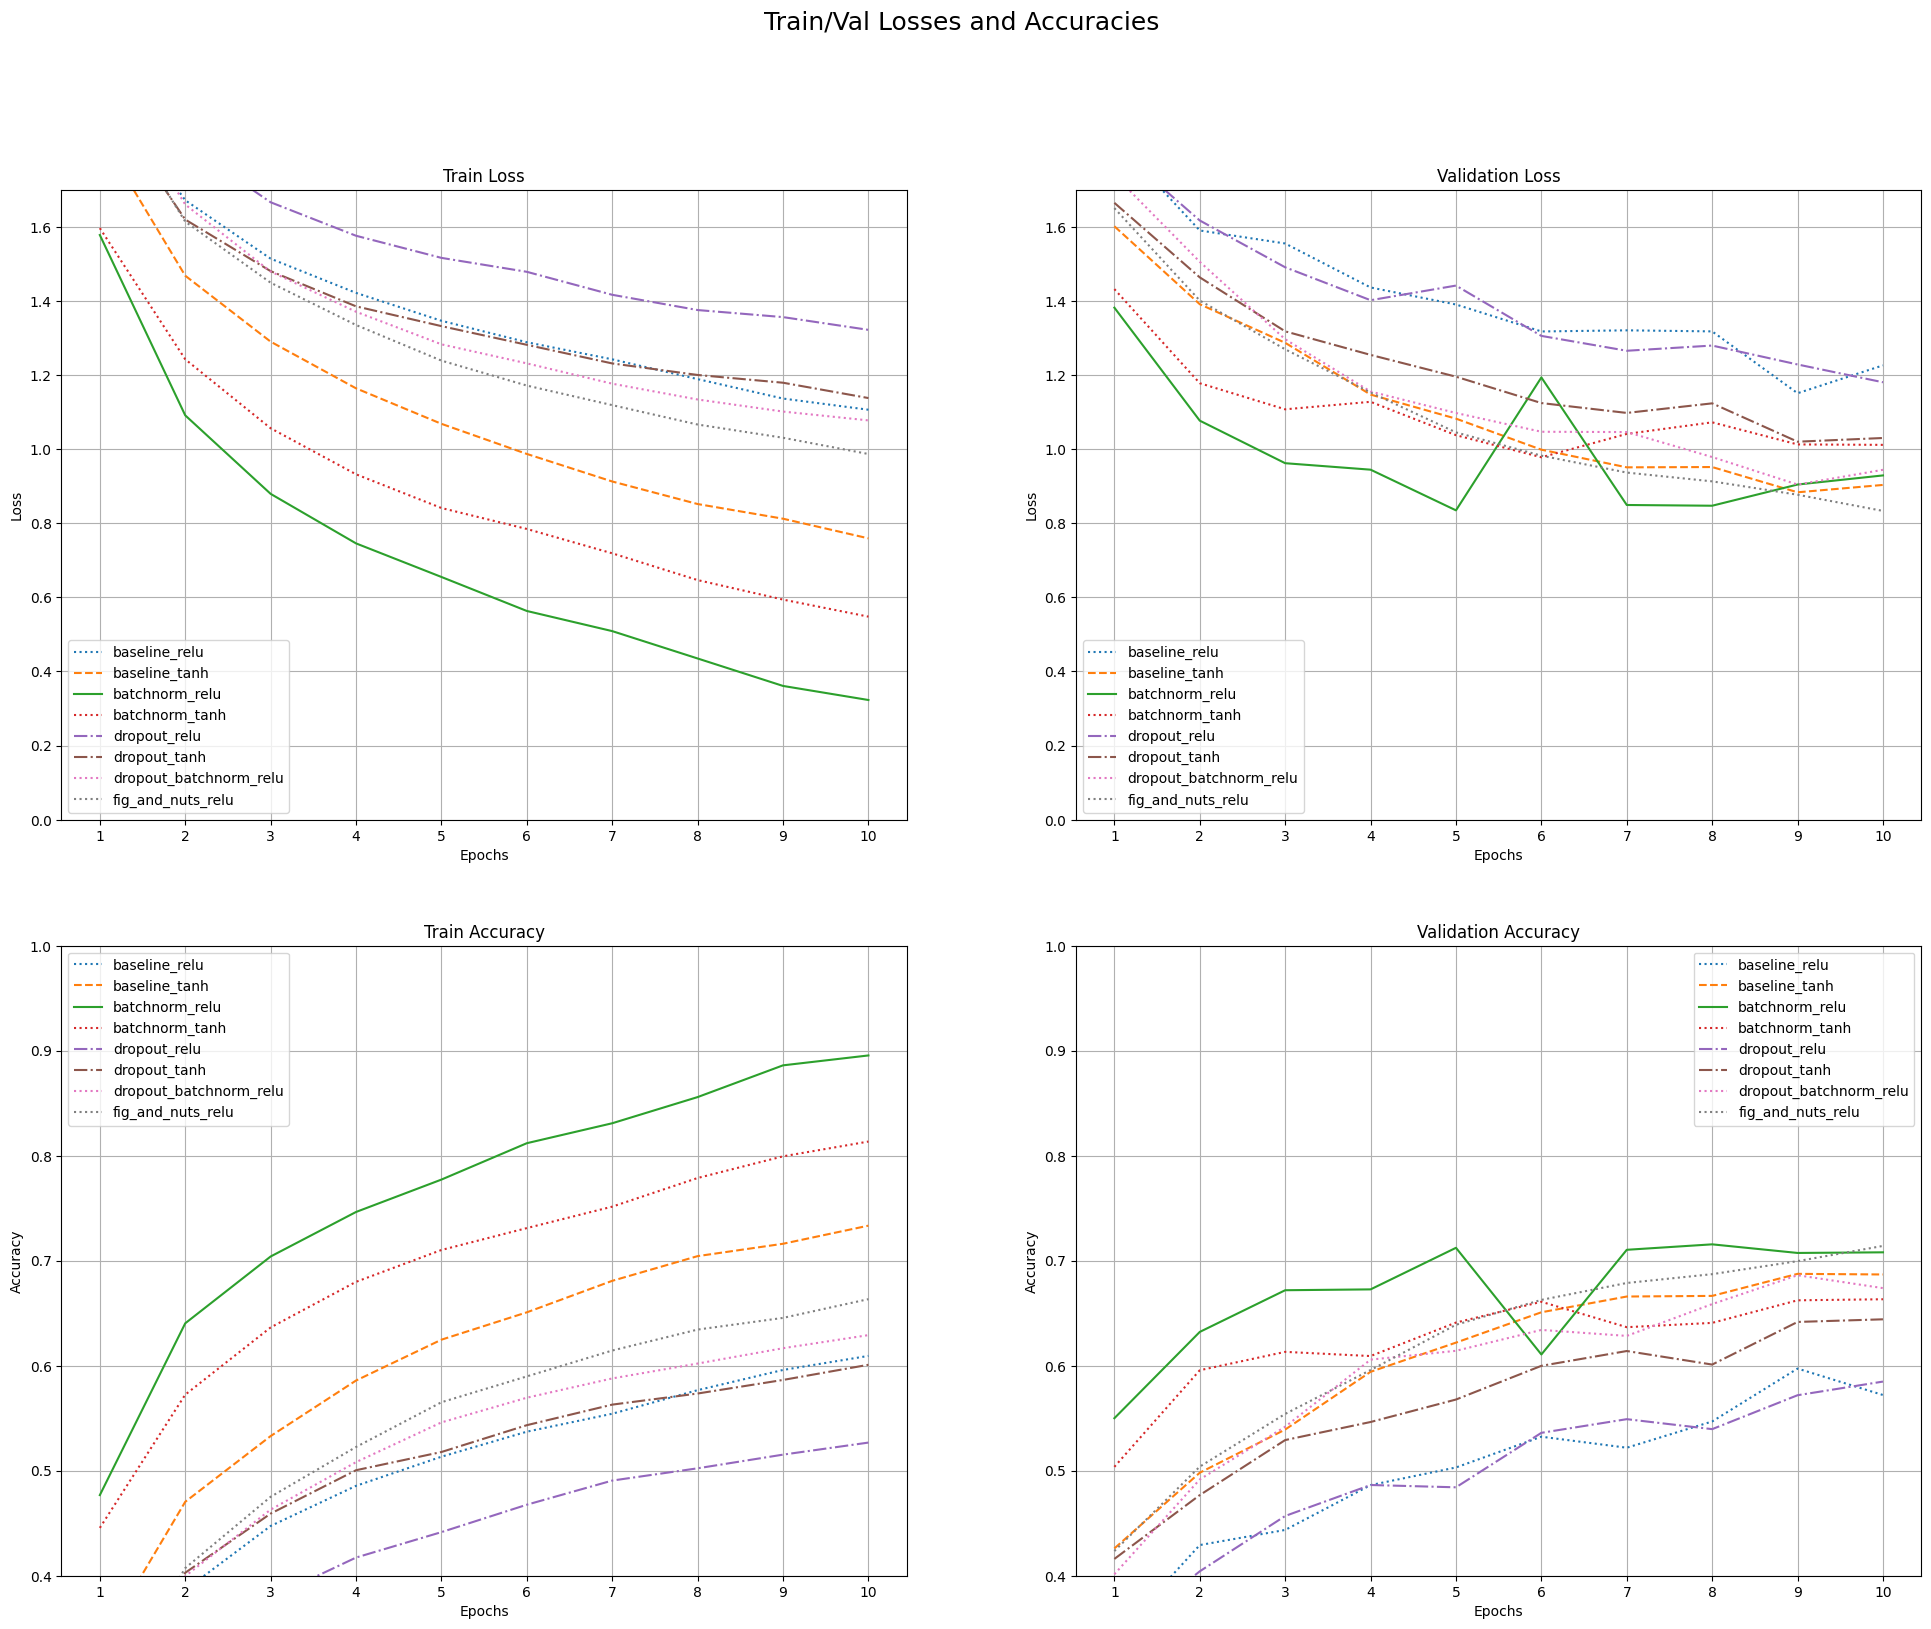

In [22]:
plot_loss_curves(n_epochs, results)

In [25]:
def plot_loss_curve(n_epochs, train_losses, val_losses, train_acc, val_acc):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,6), layout='tight')

    ax[0].plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
    ax[0].plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_xticks(range(1, n_epochs+1))
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(range(1, n_epochs + 1), train_acc, label='Training Accuracy')
    ax[1].plot(range(1, n_epochs + 1), val_acc, label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_xticks(range(1, n_epochs+1))
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0,1)
    ax[1].grid()
    ax[1].legend()

    fig.suptitle('Train/Val Losses and Accuracies')
    plt.show()

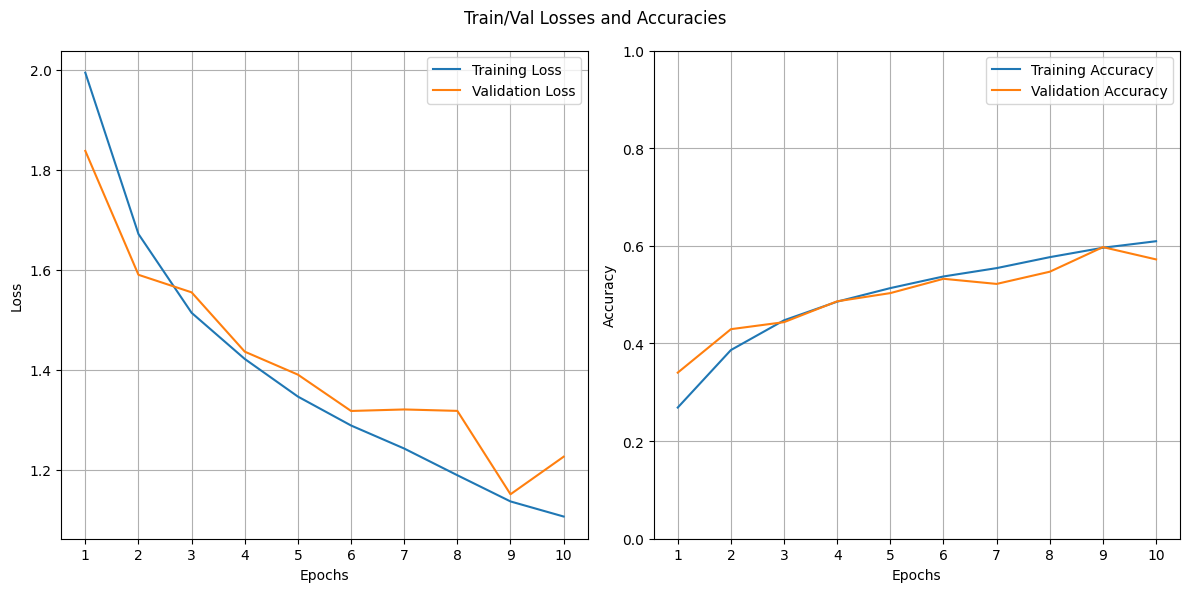

In [35]:
result = results.get('baseline_relu')
plot_loss_curve(n_epochs, result[0], result[1], result[2], result[3])

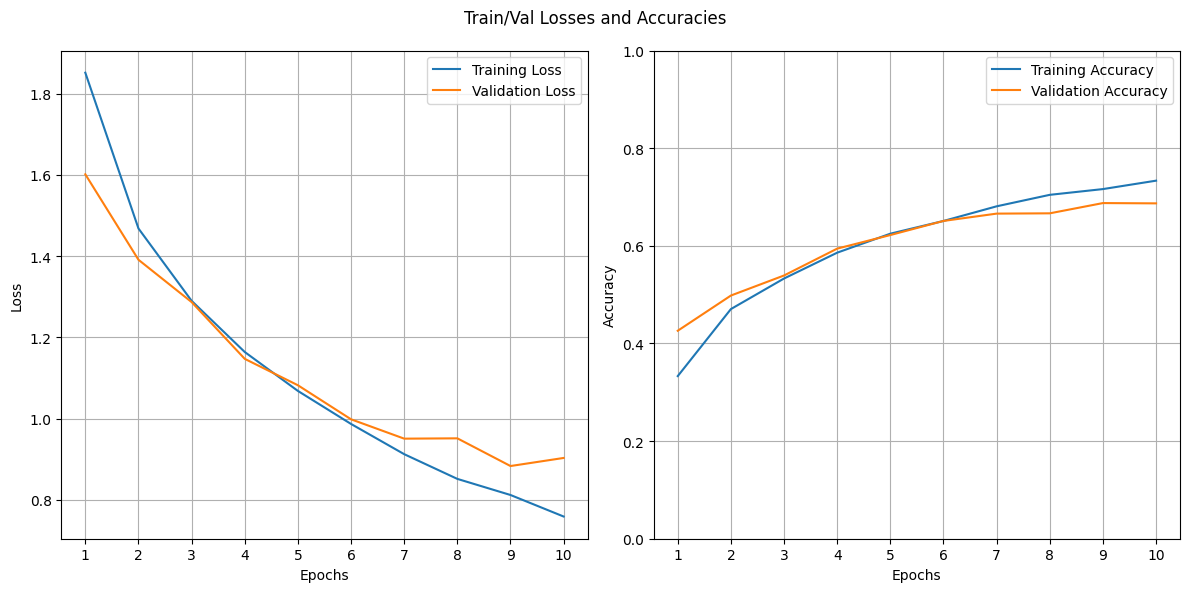

In [36]:
result = results.get('baseline_tanh')
plot_loss_curve(n_epochs, result[0], result[1], result[2], result[3])

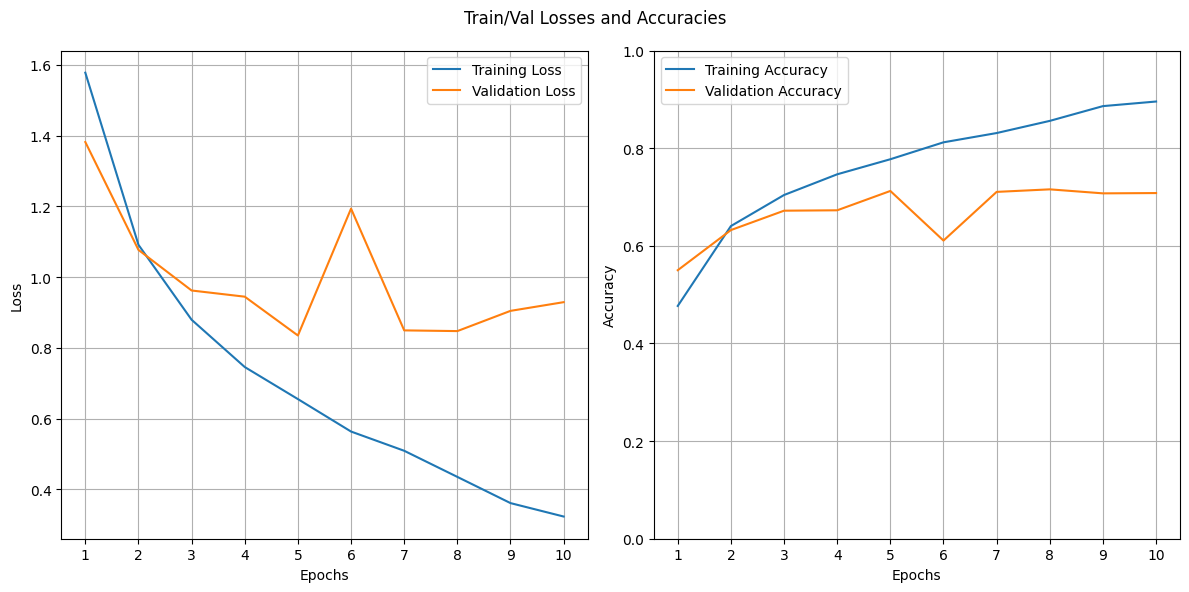

In [37]:
result = results.get('batchnorm_relu')
plot_loss_curve(n_epochs, result[0], result[1], result[2], result[3])

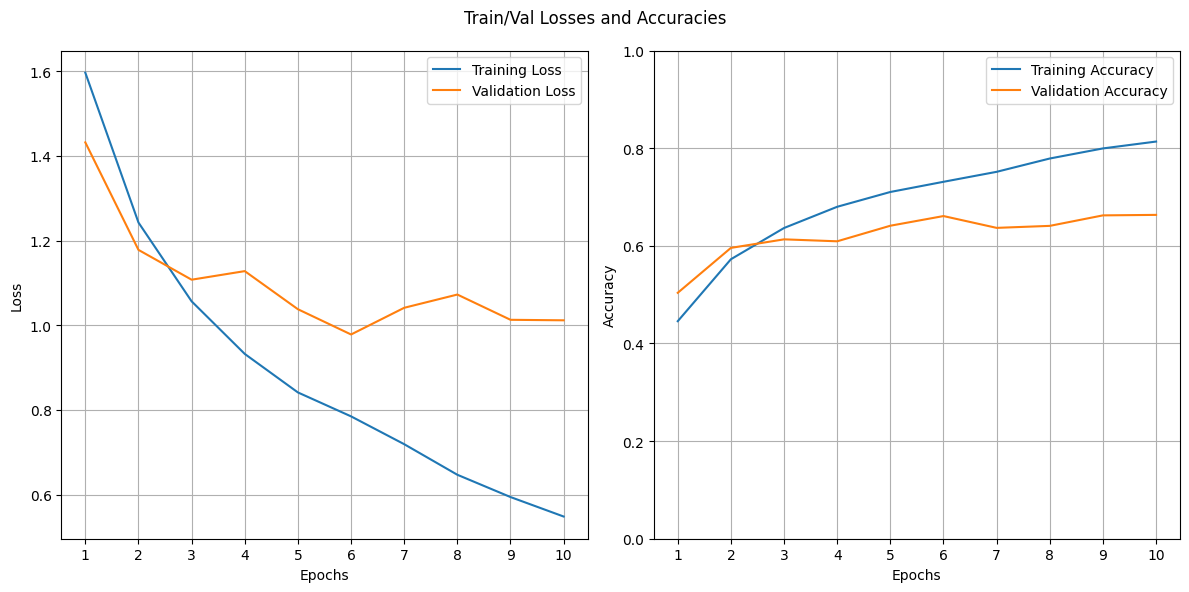

In [38]:
result = results.get('batchnorm_tanh')
plot_loss_curve(n_epochs, result[0], result[1], result[2], result[3])

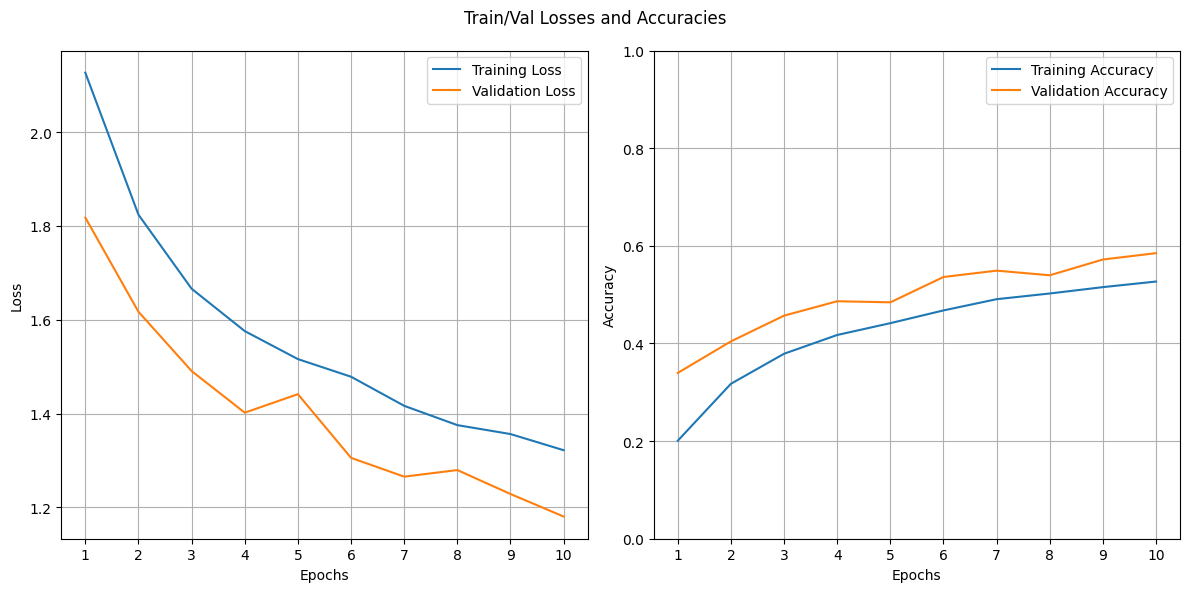

In [39]:
result = results.get('dropout_relu')
plot_loss_curve(n_epochs, result[0], result[1], result[2], result[3])

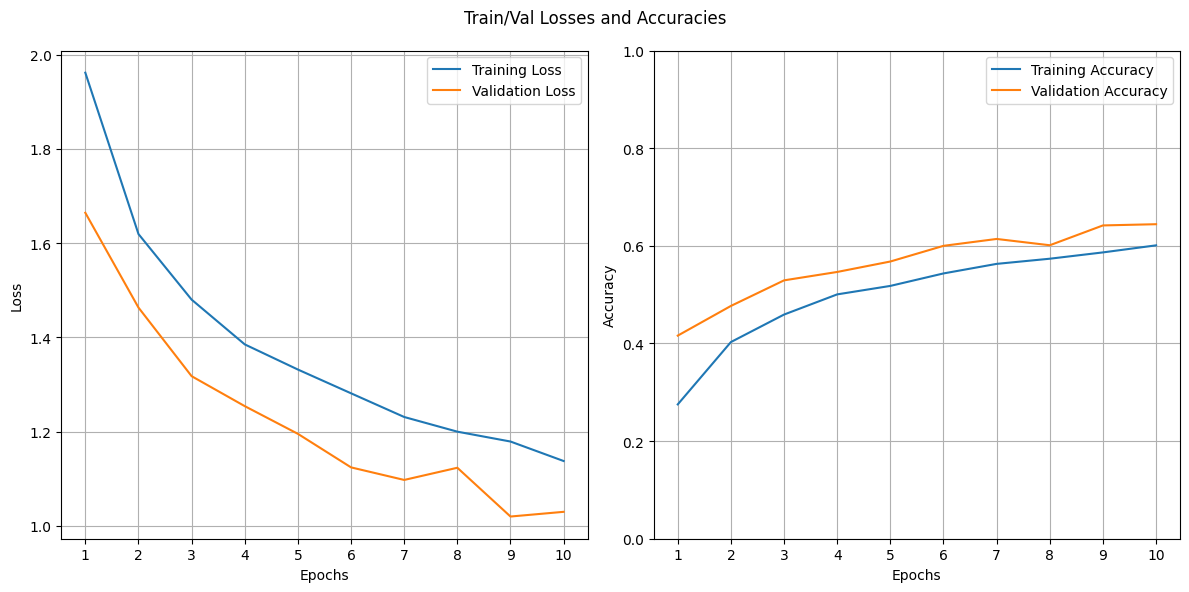

In [40]:
result = results.get('dropout_tanh')
plot_loss_curve(n_epochs, result[0], result[1], result[2], result[3])

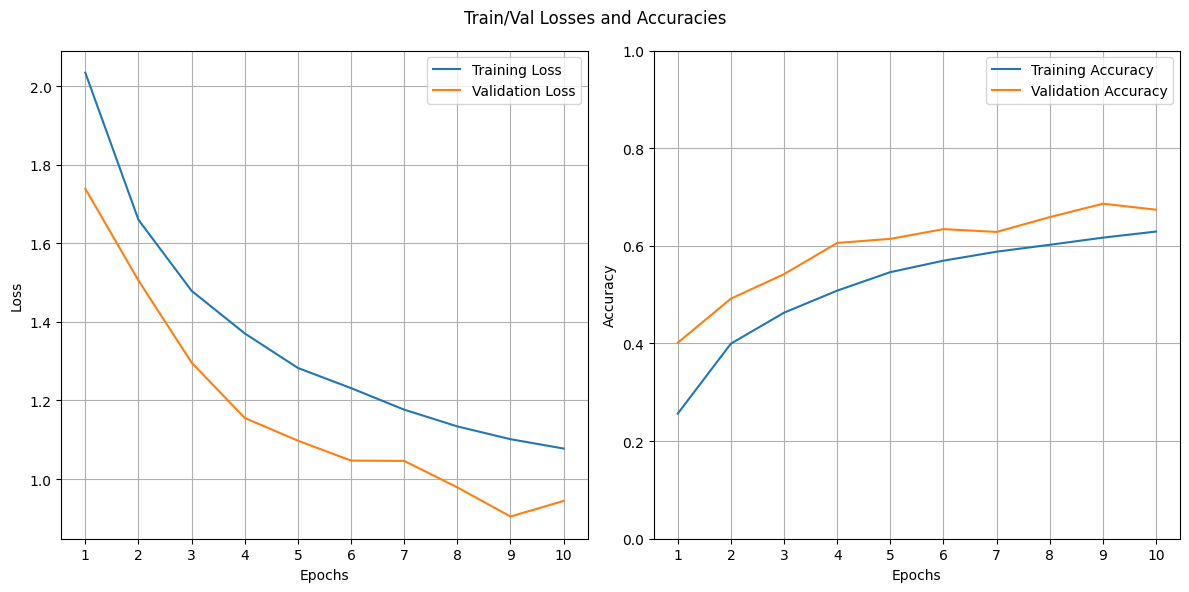

In [33]:
result = results.get('dropout_batchnorm_relu')
plot_loss_curve(n_epochs, result[0], result[1], result[2], result[3])

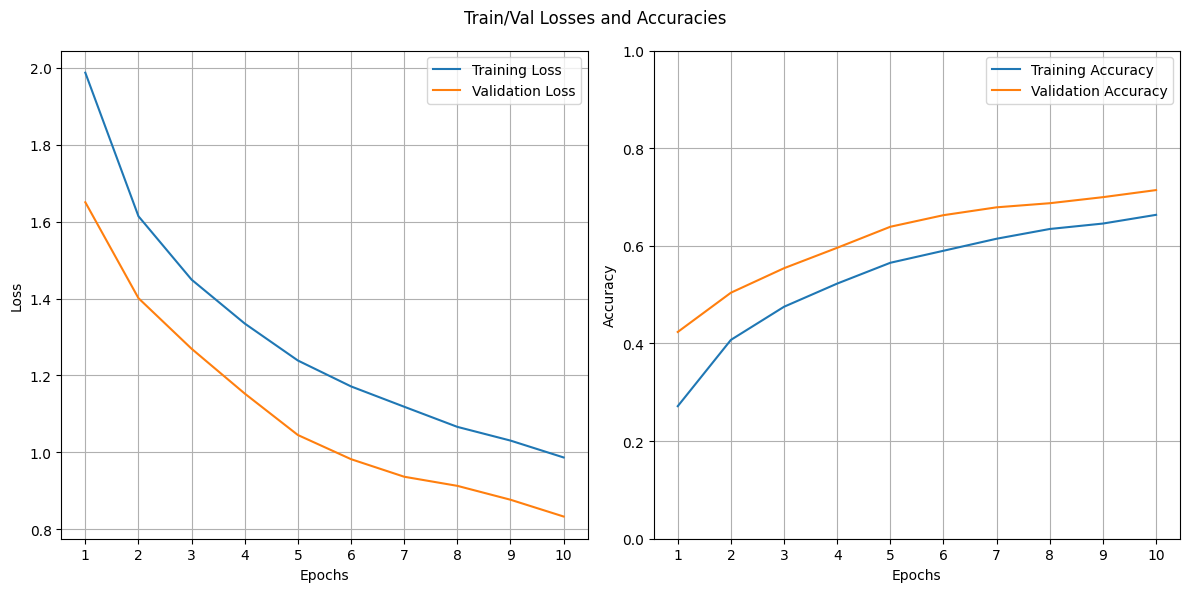

In [34]:
result = results.get('fig_and_nuts_relu')
plot_loss_curve(n_epochs, result[0], result[1], result[2], result[3])

## Discussion

In general the results are as expected.

1. **Baselines**: Interestingly, the tanh slightly outperforms ReLU, which is unexpected given the typical dominance of ReLU in deep learning models. Tanh may provide a smoother optimization landscape for this specific architecture and dataset.
2. **BatchNorm**: As we've learned, BatchNorm speeds up training by stabilizing the distribution of activations. However, it can also lead to faster overfitting. In this case, BN combined with ReLU shows better performance.
3. **Dropout**: Since Dropout prevents overfitting by forcing the model to not rely too much on specific neurons, it leads to a model that generalizes better.
4. **Dropout and BatchNorm**: When combined, BN + Dropout takes advantage of the strengths of both techniques: faster, more stable, and less prone to overfitting.
5. **Fig N Nuts**: The Fig and Nuts variant shows more stable performance across epochs compared to the Dropout + BN architecture.